# Clustering

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

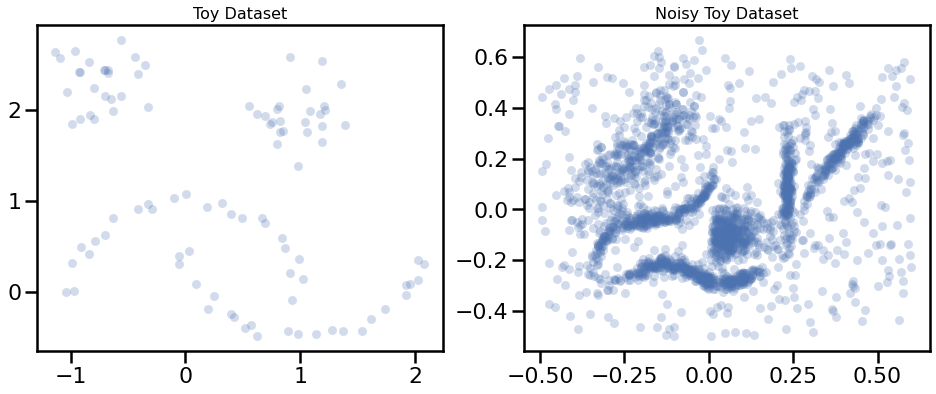

In [5]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data-1.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

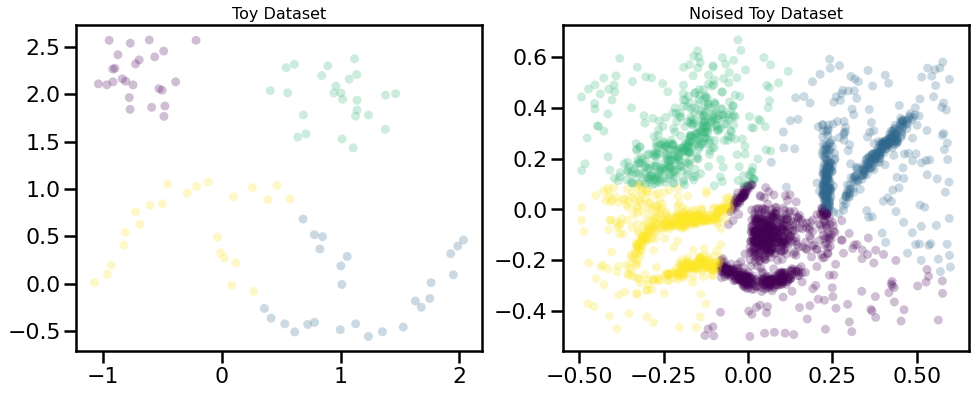

In [3]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

In [4]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
   
        n_samples, n_features = X.shape
        
        #create initial distance matrix
        assert self.metric_ in ["precomputed", "euclidean"], "metric should be 'precomuted' or 'euclidean' "
        if self.metric_ is "precomputed":
            D = X
        if self.metric_ is "euclidean":
            dist_vect = distance.pdist(X, metric="euclidean")
            D = distance.squareform(dist_vect)
        
        #initialize hierarchy matrix
        self.hierarchy_ = []
        self.hierarchy_.append(np.array(list(range(n_samples))))
        
        iteration=0
        while iteration<n_samples-1:
        
            #find the 2 closest points
            closest_points = np.where(D == np.min(dist_vect[np.nonzero(dist_vect)]))
            s,t = closest_points[0][-1], closest_points[1][-1]
            
            #add new level hierarchy
            new_level = self.hierarchy_[-1]
            new_level = np.where(new_level!=s, new_level, n_samples+iteration)
            new_level = np.where(new_level!=t, new_level, n_samples+iteration)
            self.hierarchy_.append(new_level)
            
            
            #update linkage matrix
            #first compute nbre of original points in the new merge
            nb=0
            if s<n_samples:
                nb+=1
            else:
                nb+=self.linkage_matrix_[s-n_samples,3]
            if t<n_samples:
                nb+=1
            else:
                nb+=self.linkage_matrix_[t-n_samples,3]
                
            new_merge = np.array([t,s,D[s,t],nb])
            #add the merge row
            if self.linkage_matrix_ is not None:
                self.linkage_matrix_ = np.vstack([self.linkage_matrix_, new_merge])
            else:
                self.linkage_matrix_ = new_merge.reshape(1,4)
            
            #update distance matrix
            n1 = D.shape[0]
            new_distances = np.zeros(n1+1)
            for k in range(n1):
                if k!=s and k!=t:
                    new_distances[k] = min(D[k,s],D[k,t])
                    
            D = np.vstack([D,new_distances[:-1]])
            D = np.column_stack([D,new_distances])
            
            D[:,s]=0
            D[s,:]=0
            D[:,t]=0
            D[t,:]=0
            
            dist_vect = distance.squareform(D)

            iteration+=1
            
        assert self.n_clusters_ <= n_samples, "More cluster than samples !"
        self.labels_ = self.hierarchy_[-self.n_clusters_]
        
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''
        dendrogram(self.linkage_matrix_)
        plt.show()

<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:59: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:59: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-4-2d8a118a7b4a>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.metric_ is "precomputed":
<ipython-input-4-2d8a118a7b4a>:59: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.metric_ is "euclidean":


Apply the method to our toy datasets

In [5]:
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram
import time

#fit test_data_0
start = time.time()
single_linkage_0 = my_SingleLinkageAglomerativeClustering(n_clusters=4)
single_linkage_0.fit(test_data_0)
print("time to fit test_data_0 : ", time.time() - start)

#fit test_data_1

start = time.time()
single_linkage_1 = my_SingleLinkageAglomerativeClustering(n_clusters=4)
single_linkage_1.fit(test_data_1)
print("time spent to fit test_data_1 : ", time.time() - start)

time to fit test_data_0 :  0.04937624931335449
time spent to fit test_data_1 :  662.1936872005463


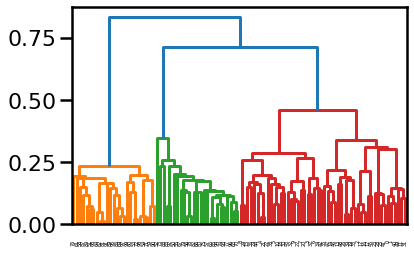

In [8]:
#plot dendogram for test_data_0
single_linkage_0.plot_dendrogram()

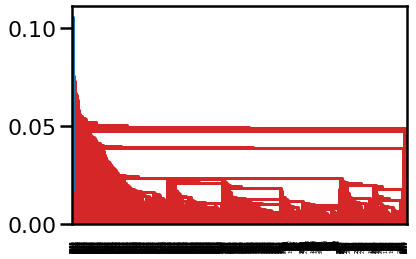

In [6]:
#plot dendogram for test_data_1
single_linkage_1.plot_dendrogram()

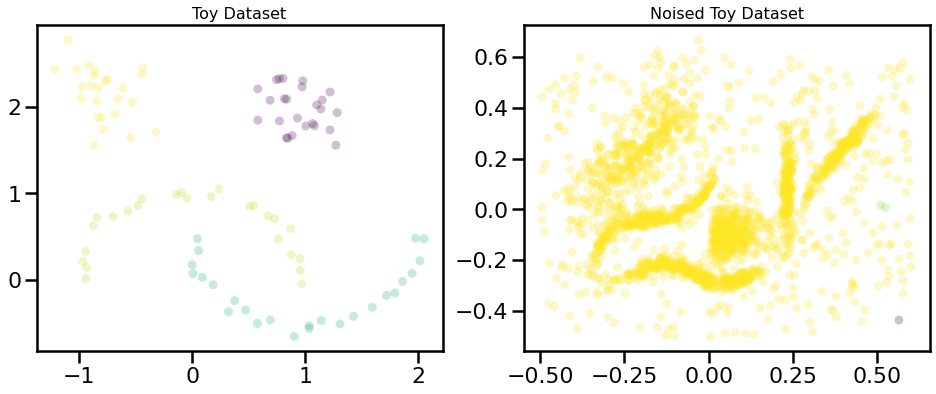

In [9]:
#check the clustering on toy data
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=single_linkage_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=single_linkage_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)
plt.show();

Try the different linkage methods implemented in `sklearn`  and comment

**Comments**
- Single linkage is fast, and has the best performance on non-noisy data (the only linkage method to successfully divide our toy data into 4 correct clusters), BUT it performs poorly in the presence of noise.
- Average and complete linkage perform well on simple and separated clusters, have similar fitting time. In the case of noisy data, they have different results; we can clearly see that the clusters of each of these linkage methods are diffrent in size.
- Ward is the most effective method for noisy data, but takes longer time.


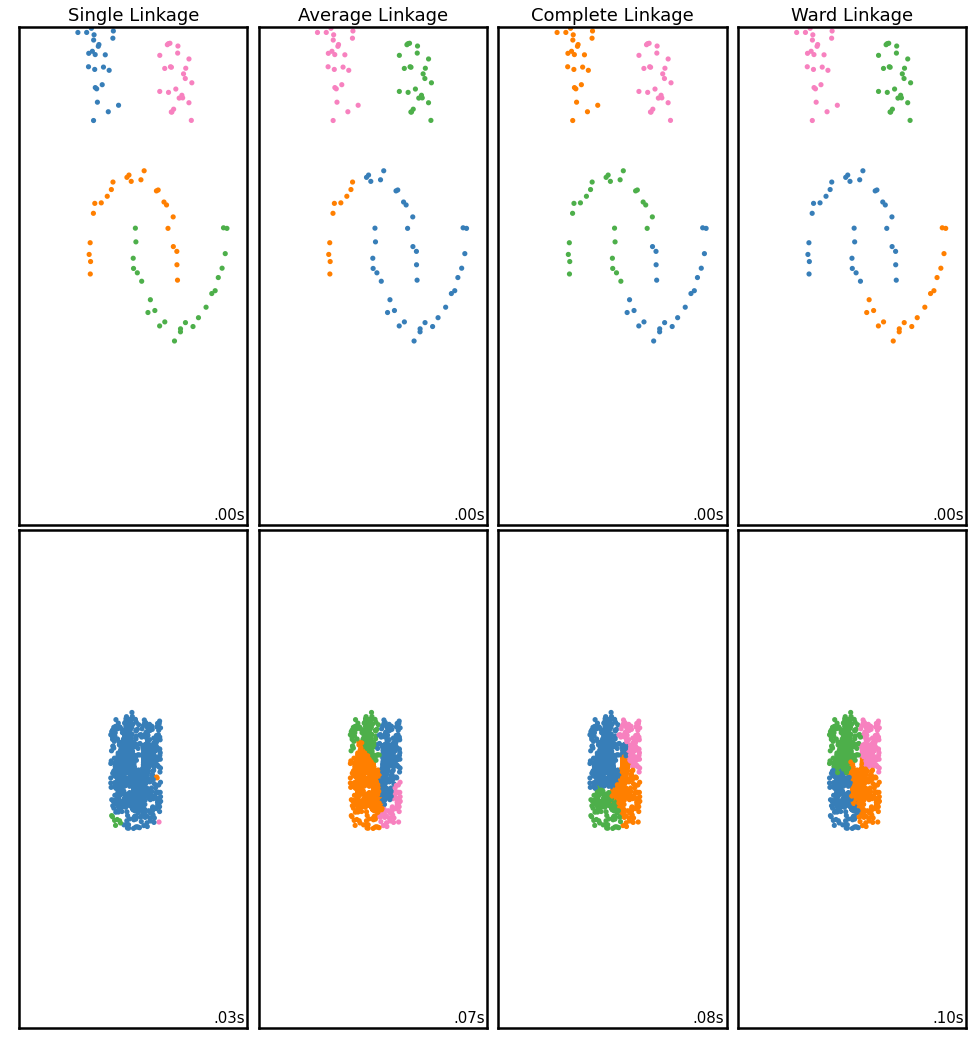

In [11]:
from sklearn import cluster
from itertools import cycle, islice
#create cluster objects

# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1


datasets = [
    (test_data_0, {'n_clusters': 4}),
    (test_data_1, {'n_clusters': 4}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):

    X= dataset
    # Create cluster objects
    ward = cluster.AgglomerativeClustering(
        n_clusters=algo_params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=algo_params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=algo_params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=algo_params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

We will apply it to the test_data and see how to tune the parameters

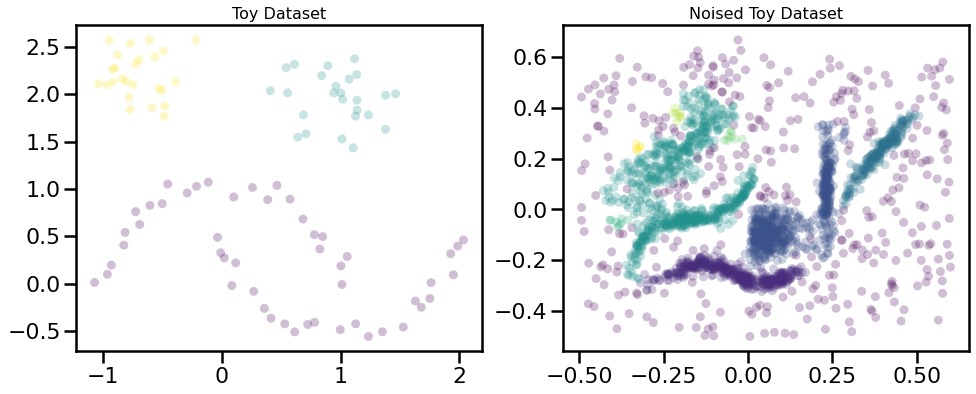

In [5]:
from sklearn.cluster import DBSCAN

dbscan_cluster_0 = DBSCAN().fit(test_data_0)
dbscan_cluster_1 = DBSCAN(eps=0.025, min_samples=5).fit(test_data_1)


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan_cluster_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=dbscan_cluster_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

#### Tuning the DBSCAN model

When attempting to segment the noisy data into clusters using the dbscan algorithm, it is clear that we need to put in more effort into parameter tuning. 
For this reason we choose to play on the two most imprtant parameters for dbscsn: eps (he maximum distance between two samples for one to be considered as in the neighborhood of the other.) and min_samples (The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.)

For this, we have tried to play around manually with the parameters to find fit closest to best, for example an eps of the order of 10^-2 is miles better than the default value, same with min_samples. 
But this way is very arbitrary, it is possible to apply elbow methods to find somewhat "optimal" values of eps and min_samples. Unfortunately we did not have enough ime to completely implement these methods. For example for a panorama of possible eps values that give best performances, we represnted the curve of distances between the points.(following 2 cells down below) 
We weren't however able to do an exhaustive evaluation of these possible eps values. 

In [6]:
import pandas as pd
test_data_pd = pd.DataFrame (test_data_1)
test_data_pd = test_data_pd.sort_values(by=[0, 1])
df2 = pd.DataFrame(columns = ['index', 'distance'])
for i in range (len(test_data_pd) - 1):
    dist = np.linalg.norm(test_data_pd.iloc[i]- test_data_pd.iloc[i+1])
    df2 = df2.append({'index': str(i), 'distance': dist}, ignore_index=True)

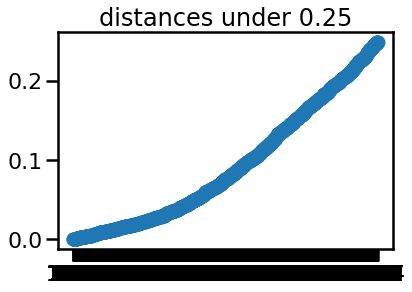

In [7]:
df3 = df2[df2['distance'] < 0.25]
df3 = df3.sort_values(by=['distance'])
plt.figure()
plt.scatter(df3['index'], df3['distance'])
plt.title('distances under 0.25')
plt.show()

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

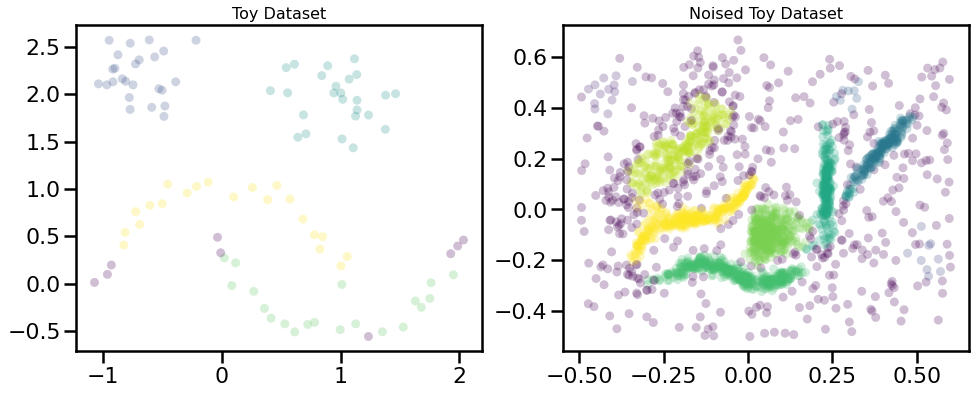

In [7]:
import hdbscan

clusterer_0 = hdbscan.HDBSCAN()
clusterer_0.fit(test_data_0)

clusterer_1 = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=8)
clusterer_1.fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=clusterer_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=clusterer_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show()

#### hdbscan parameter tuning

For the hdbscan implemntation, we notice that for the noisy data, if the min_samples parameter (The number of samples in a neighbourhood for a point to be considered a core point) is left to its default value (None) or set to a smaller value (for example 1 or 2) the algorithm doesn't succeed in making a clear disjunction between the different clusters.

## Applying the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


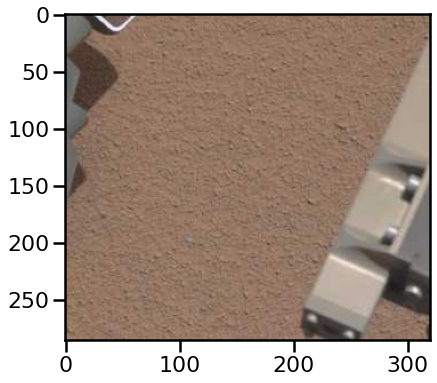

In [8]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced-1.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [9]:
# TODO:
# I = 
# S = 
Im_1_array = np.array(Im_1)
I_S_Image = np.zeros((Im_1_array.shape[0], Im_1_array.shape[1], 2))
for i in range ((Im_1_array.shape[0])):
    for j in range ((Im_1_array.shape[1])):
        intensity = (Im_1_array[i,j,0] +  Im_1_array[i,j,1] +  Im_1_array[i,j,2]) / 3
        saturation = 1 - intensity * min(Im_1_array[i,j,0], Im_1_array[i,j,1], Im_1_array[i,j,2])
        (I_S_Image[i,j, 0], I_S_Image[i,j, 1]) = (intensity, saturation)

<ipython-input-9-75988180e858>:8: RuntimeWarning: overflow encountered in ubyte_scalars
  intensity = (Im_1_array[i,j,0] +  Im_1_array[i,j,1] +  Im_1_array[i,j,2]) / 3


In [11]:
I_S_Image.shape

(286, 320, 2)

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

In [12]:
#single linkage 

from sklearn import cluster 
single_clusterer = cluster.AgglomerativeClustering(n_clusters=300, linkage='single')
single_clusterer.fit(I_S_Image.reshape((-1, 2)))
labels_single = single_clusterer.labels_.astype(np.int)

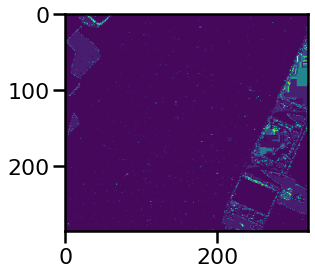

In [13]:
#results visualisation 
plt.imshow(np.reshape(labels_single, Im_1_array.shape[0:2]))

In [24]:
#Kmeans
from sklearn.cluster import KMeans
kmeans_clusterer = KMeans(n_clusters=100, max_iter=300).fit(I_S_Image.reshape((-1, 2)))
labels, centers = kmeans_clusterer.labels_, kmeans_clusterer.cluster_centers_

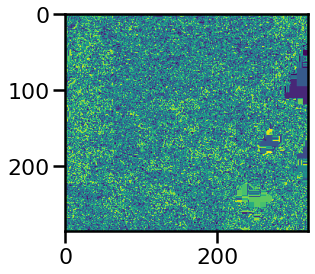

In [25]:
#results visualisation 
plt.imshow(np.reshape(labels, Im_1_array.shape[0:2]))

In [16]:
#DBSCAN
from sklearn.cluster import DBSCAN
dbscan_clusterer = DBSCAN(eps=5, min_samples=50, metric = 'euclidean',algorithm ='auto').fit(I_S_Image.reshape((-1, 2)))
dbscan_labels = dbscan_clusterer.labels_

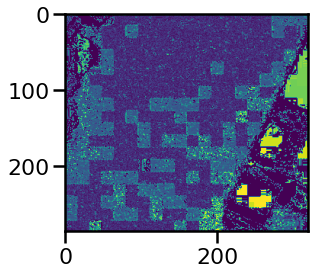

In [17]:
plt.imshow(np.reshape(dbscan_labels, Im_1_array.shape[0:2]))

In [18]:
#hdscan
import hdbscan
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=450, min_samples=None,algorithm='boruvka_kdtree')
hdbscan_clusterer.fit(I_S_Image.reshape((-1, 2)))
hdbscan_labels =hdbscan_clusterer.labels_ 
hdbscan_exemplars = hdbscan_clusterer.exemplars_

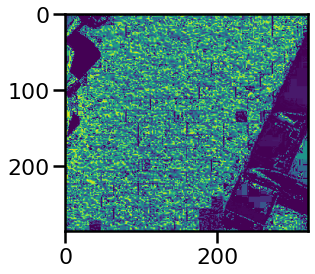

In [20]:
#visualisation 
plt.imshow(np.reshape(hdbscan_labels, Im_1_array.shape[0:2]))

#### Interpretation of our results

Applying the previously seen methods, single linkage Kmeans dbscan and hdbscan, to the intenity saturation representation of the image didn't seem to us at first very meaningful. As we didin't have a clear goal for the segmentation and the visualization of results didn't help to make it clearer either. 

The problem was, with the metallic parts in the image the task was noised by these segments and implementing these algorithms with a smalll number of clusters wasn't enough. We needed to segment into multiple smaller clusters. Squares started to appear in the mars surface part of the picture, And going back to the original image we miht be able to distinguish some discoloration in the dirt, but it wasn't very obvious to the eye. So segmentation helped make it clearer that these dicolorations actually existed (the squares in the segmentation visualization) an interpertation of this could be the existence of minerals on mars that have those different colour from the dirt. 

The best performing algorithm, visually, was the dbscan implementation which marqued the squares of discolorations more prominently. 

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

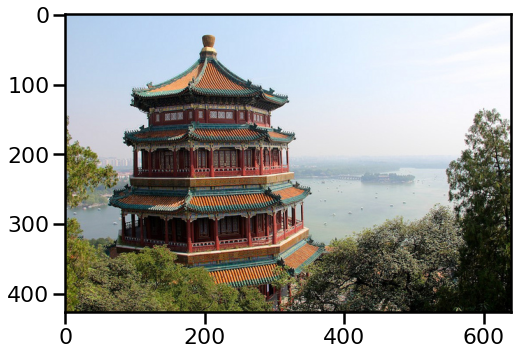

In [21]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

In [22]:
# TODO
#rescaling image to array of pixels with 3 coordinates (R,G,B)
pixel_values = china.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

#Kmeans clustering 
K_means_colors = KMeans(n_clusters=10).fit(pixel_values)
comp_centers, comp_labels = K_means_colors.cluster_centers_, K_means_colors.labels_
comp_centers = np.uint8(comp_centers)
new_image = comp_centers[comp_labels]

# reshape back to the original image dimension
new_image = new_image.reshape(china.shape)

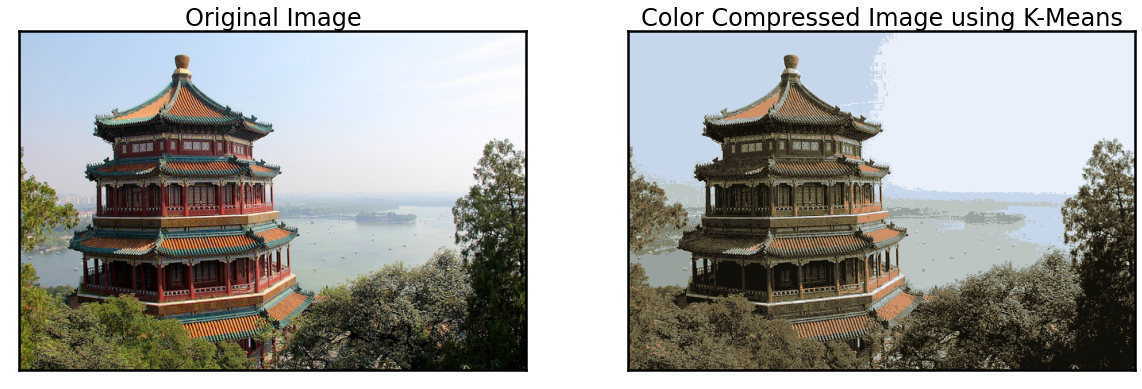

In [23]:
#visualising new compressed image 
fig = plt.figure(figsize=(20,20)) 
ax=fig.add_subplot(1,2,1,xticks=[],yticks=[],title='Original Image') 
ax.imshow(china) 
ax=fig.add_subplot(1,2,2,xticks=[],yticks=[],title='Color Compressed Image using K-Means') 
ax.imshow(new_image) 
plt.show() 